# **VAE Model**

### **i. Imports and subfunctions**

In [1]:
# Imports
import copy
import torch
import tqdm
import gc
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from numba import cuda 
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision import transforms, datasets

def split_iid(dataset, n_centers):
    """ Split PyTorch dataset randomly into n_centers."""
    n_obs_per_center = [len(dataset) // n_centers for _ in range(n_centers)]
    return random_split(dataset, n_obs_per_center)

def federated_averaging(models, n_obs_per_client):
    """ Perform federated averaging."""
    # Error check inputs
    assert len(models) > 0
    assert len(n_obs_per_client) == len(models)

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

def loss_plot(epochs, loss, axs=False):
    """ Plot loss curve."""
    if axs:
      axs.plot(epochs, loss)
    else:
      plt.plot(epochs, loss)

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

def denorm(x, mean, std):
    """ 
    Function to reverse the normalization so that we can visualise the outputs
    """
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    x = unnormalize(x)
    return x


### **ii. General setup**

In [4]:
# Working environment
WORKING_ENV = 'LABS'
if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    content_path = '/content/drive/MyDrive/federated_autoencoder'
    data_path = './data/'
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

# Training hyperparameters
N_ROUNDS = 10
N_CENTRES = 4
N_EPOCHS = 50
N_FEATURES = 784
BATCH_SIZE = 128
HIDDEN_DIM = 400
LATENT_DIM = 200

# GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()
    device = cuda.get_current_device()
    device.reset()

# Load data
mean = torch.Tensor([0.1307])
std = torch.Tensor([0.3081])
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="~/torch_datasets", train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root="~/torch_datasets", train=False,
                              transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

# Federate data
federated_dataset = split_iid(train_dataset, n_centers=4)
print('Number of centers:', len(federated_dataset))

# Put data into dataloader
for i, dataset in enumerate(federated_dataset):
    federated_dataset[i] = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                       shuffle=True, num_workers=2, pin_memory=True)

Number of centers: 4


## **1. Create models**

In [5]:
class VAE(nn.Module):
    def __init__(self,
                 in_channels=1,
                 latent_dim=200,
                 feature_dim=[32, 20, 20]):
        super(VAE, self).__init__()

        # Assign variables
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.feature_dim = feature_dim
        self.total_feature_dim = self.feature_dim[0]*self.feature_dim[1]*self.feature_dim[2]
        modules = []

        # Build Encoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(self.in_channels, 16, kernel_size=5),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.Conv2d(16, 32, kernel_size=5),
                nn.BatchNorm2d(32),
                nn.LeakyReLU()
                )
        )

        # Build encoder
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(self.total_feature_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.total_feature_dim, self.latent_dim)

        # Build decoder
        modules = []
        self.decoder_input = nn.Linear(self.latent_dim, self.total_feature_dim)
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(32, 16,
                                   kernel_size=5),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(16, self.in_channels,
                                   kernel_size=5),
                nn.BatchNorm2d(self.in_channels),
                nn.Sigmoid()
                )
        )
        self.decoder = nn.Sequential(*modules)
      
    def encode(self, x):
        """ Encode input to mean and logvar."""
        # Get values from encoding features
        result = self.encoder(x)
        result = result.view(result.shape[0], self.total_feature_dim)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)
        return [mu, logvar]
    
    def reparameterise(self, mu, logvar):
        """ Reparameterise to sample."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        """ Decode latent sampling to output."""
        result = self.decoder_input(z)
        result = result.view(result.shape[0], self.feature_dim[0],
                             self.feature_dim[1], self.feature_dim[2])
        result = self.decoder(result)
        return result

    def forward(self, x):
        """ Forward pass of the network."""
        # Check input length matches in_features
        # if x.shape[-1] != self.in_features:
        #     raise Exception(f'Input features must be equal to {self.in_features}!')

        # Encode input to mean and logvar
        mu, logvar = self.encode(x)

        # Reparameterise
        z = self.reparameterise(mu, logvar)

        # Decode and return values
        return [self.decode(z), x, mu, logvar]
    
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.criterion = F.binary_cross_entropy

    def forward(self, outputs, inputs, mu, logvar, Beta=5):   
        recon_loss = self.criterion(outputs, inputs, reduction='sum')
        kl = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())
        return recon_loss, kl, recon_loss + kl

## **2. Train VAE**

In [6]:
# Initialise model
StandardVAE = VAE(in_channels=1, latent_dim=200).to(device)
params = sum(p.numel() for p in StandardVAE.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(StandardVAE)

# Optimiser and loss
optimizer = torch.optim.Adam(StandardVAE.parameters(), lr=1e-3)
criterion = VAELoss()

Total number of parameters is: 7719795
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=12800, out_features=200, bias=True)
  (fc_var): Linear(in_features=12800, out_features=200, bias=True)
  (decoder_input): Linear(in_features=200, out_features=12800, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): ConvTranspose2d(16, 1, kernel_size=(5, 5), str

In [7]:
# Initialise model
StandardVAE.train()
losses = {'recon': [],
          'kl': [],
          'training': []
          }
print('Beginning standard VAE training...\n')
for epoch in range(N_EPOCHS):
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_train_loss = 0.0
    with tqdm.tqdm(train_loader, unit="batch") as tepoch: 
        for batch_idx, batch in enumerate(tepoch):  
          # Batch tensor
          batch_tensor = batch[0].to(device)

          # Compute reconstructions
          results, x, mu, logvar = StandardVAE(batch_tensor)

          # Loss
          F.binary_cross_entropy(results, batch_tensor)
          recon_loss, kl_loss, train_loss = criterion(results, batch_tensor,
                                                      mu=mu, logvar=logvar)

          # Backpropagation based on the loss
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()

          # Update loss
          running_recon_loss += recon_loss.item()
          running_kl_loss += kl_loss.item()
          running_train_loss += train_loss.item()

          # Log
          if batch_idx % 20 == 0:
            tepoch.set_description(f"Epoch {epoch+1}")
            tepoch.set_postfix(loss=train_loss.item())

        # Average epoch loss
        losses['recon'].append(running_recon_loss/batch_idx+1)
        losses['kl'].append(running_kl_loss/batch_idx+1)
        losses['training'].append(running_train_loss/batch_idx+1)

Beginning standard VAE training...



Epoch 1:  18%|█▊        | 85/469 [00:02<00:06, 62.38batch/s, loss=5.65e+4]

## **2.1 Loss curves**

In [1]:
# Loss plots
fig, axs = plt.subplots(1,3, figsize=(30,10))
plt.suptitle("Loss Curves for Standard VAE")
for i, k in enumerate(losses):
  loss_plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), losses[k], axs=axs[i])
  axs[i].set_title(f"{k} loss")


NameError: name 'plt' is not defined

## **3. Analyse VAE**

Input images
--------------------------------------------------


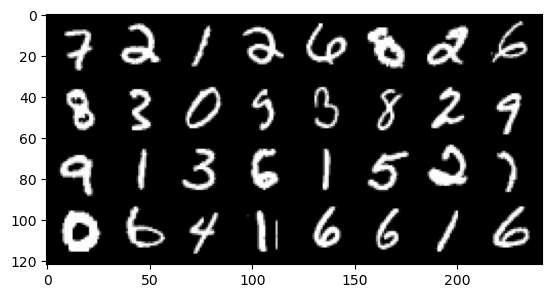

Reconstructed images
--------------------------------------------------


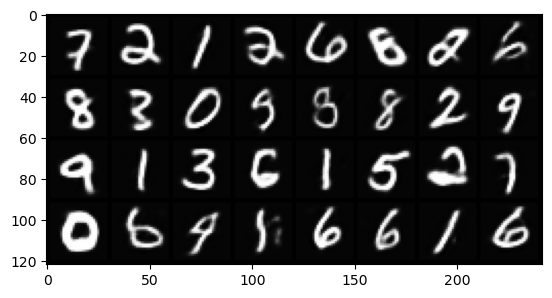

Generated Images
--------------------------------------------------


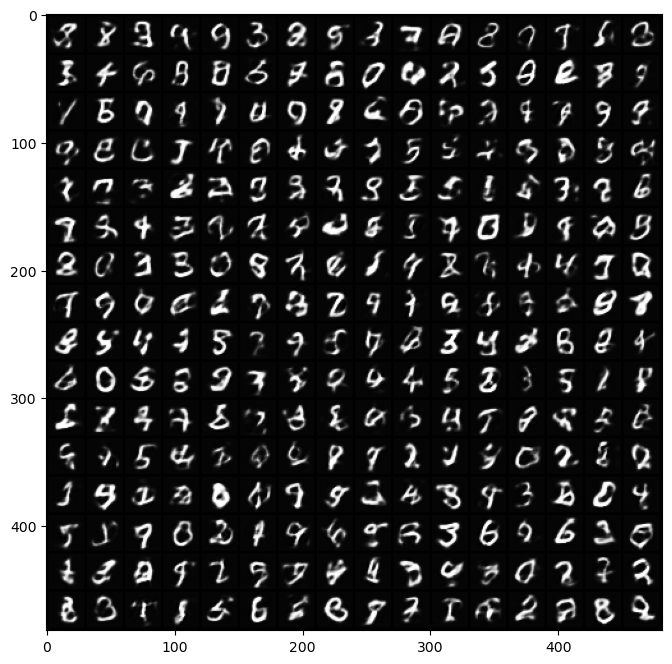

In [7]:
# Visualise original images
print('Input images')
print('-'*50)
sample_inputs, _ = next(iter(test_loader))
fixed_input = sample_inputs[0:32, :, :, :]
img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)
plt.show()


print('Reconstructed images')
print('-'*50)
StandardVAE.eval()
with torch.no_grad():
    # Visualize the reconstructed images of the last batch of test set
    fixed_input = fixed_input.to(device)
    recon_batch = StandardVAE(fixed_input)
    recon_batch = recon_batch[0].cpu()
    recon_batch = recon_batch.view(recon_batch.shape[0], 1, 28, 28)
    recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)
    plt.show()

print('Generated Images')  
print('-'*50)
StandardVAE.eval()
n_samples = 256
z = torch.randn(n_samples, LATENT_DIM).to(device)
with torch.no_grad():
    samples = StandardVAE.decode(z)
    samples = samples.view(n_samples, 1, 28, 28)
    samples = samples.cpu()
    samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

